<a href="https://colab.research.google.com/github/anthonymirandag/IndoorLocalization/blob/master/FingerprintingIndoorLocalization1D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import io
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
!pip install tensorflow-gpu==2.0.0.alpha0
import datetime
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
from tensorflow.keras.utils import plot_model
import math

     |████████████████████████████████| 332.1MB 48kB/s 
     |████████████████████████████████| 3.0MB 32.4MB/s 
     |████████████████████████████████| 419kB 50.3MB/s 


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

# Enfoque de Series de tiempo con CNN.
El enfoque tomado que se desea probar en usar una 1D-CNN  con la idea de aprender las caracteristica de la serie de tiempo como una ventana deslizante de los valores rssi para cada uno de los sectores. [Convolutional Neural Networks in Keras for Time Sequences](https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf)


## Obtener matrices de subsecuencias de la series de tiempo multivariada

### Carga de datos

In [6]:
target_label = 'Sector'
datasets = []
for i in range(6):
  tx = 'Tx_0x0{}'.format(i+1)
  print(tx)
  path_data = 'https://raw.githubusercontent.com/anthonymirandag/IndoorLocalization/master/data/'+tx+'.csv'
  datasets.append({"name":tx,"data":pd.read_csv(path_data)})   

Tx_0x01
Tx_0x02
Tx_0x03
Tx_0x04
Tx_0x05
Tx_0x06


In [7]:
for dataset in datasets:
  print(dataset['data'].shape)

(6873, 6)
(6961, 6)
(6626, 6)
(7174, 6)
(6760, 6)
(6718, 6)


In [8]:
datasets[0]['data'].head()

,Be07,Be08,Be09,Be10,Be11,Sector
0,-68.0,-53.0,-53.0,-59.0,-69.0,1.0
1,-65.0,-61.0,-55.0,-57.0,-63.0,1.0
2,-69.0,-54.0,-53.0,-59.0,-70.0,1.0
3,-66.0,-62.0,-52.0,-52.0,-71.0,1.0
4,-69.0,-54.0,-55.0,-62.0,-68.0,1.0


## Utils


In [0]:
def reshape_to_matrix_rssi(x_sector,size):
  total_sample ,n = x_sector.shape
  residual_elem = total_sample % size
  return x_sector[0:total_sample-residual_elem,:].reshape(-1,size,n)

In [0]:
def train_test_split_rssi(df, test_size= 0.1, random_state=27, tam_slices =20):
  x =  df.drop(target_label, axis= 1).values
  y = df[target_label].values
  labelencoder_y = LabelEncoder()
  y = labelencoder_y.fit_transform(y)  
  _, countsTotal = np.unique(y, return_counts=True)
  n = x.shape[0]
  data_shape = x.shape[1:]
  n_rand = math.floor(np.floor(countsTotal/tam_slices).sum() * 0.1)
  np.random.seed(random_state)
  n_lables = np.unique(y).shape
  rand_labels = np.random.randint(n_lables, size=n_rand)
  unique, counts = np.unique(rand_labels, return_counts=True)
  x_train = np.array([])
  x_test = np.array([])
  y_train = np.array([])  
  y_test = np.array([])
  for index, label in enumerate(unique):
    tam_block = counts[index]*tam_slices
    tam_total = y[y == label].shape[0]
    init_block = np.random.randint(tam_total-tam_block,size=1)[0] 
    x_sector = x[y == label,:]
    map_split = [[0,init_block],[init_block+tam_block,tam_total]]
    series_sector = np.array([])
    for split in map_split:
      for i in range(tam_slices):
        if(split[0]==0 and i== 0 and label == 0 ):
          series_sector = reshape_to_matrix_rssi(x_sector[0:split[1],:], tam_slices)
          x_train =  series_sector
          y_train = np.ones(series_sector.shape[0])*label 
        else:
          series_sector = reshape_to_matrix_rssi(x_sector[split[0]+i:split[1],:],tam_slices)
          x_train = np.concatenate((x_train, series_sector))
          y_train = np.concatenate((y_train,np.ones(series_sector.shape[0])*label))
    if(label == 0):
      block_sector = reshape_to_matrix_rssi(x_sector[init_block:init_block+tam_block,:],tam_slices)
      x_test = block_sector
      y_test = np.ones(block_sector.shape[0])*label       
    else:
      block_sector = reshape_to_matrix_rssi(x_sector[init_block:init_block+tam_block,:],tam_slices)
      x_test = np.concatenate((x_test,block_sector))
      y_test = np.concatenate((y_test,np.ones(block_sector.shape[0])*label))
  x_train,y_train = shuffle(x_train,y_train)
  x_test,y_test = shuffle(x_test,y_test)
  return x_train, x_test, y_train, y_test

In [0]:
def windows_slicing_aug_and_split(df,target_label ,size = 20):
  dataset = df.copy()
  x_train, x_test, y_train, y_test = train_test_split_rssi(dataset,test_size= 0.1, random_state=27, tam_slices =tam_slices)
  return x_train, x_test, y_train, y_test

In [0]:
def visualzation_accuracy_loss_values_epochs(history,title = ''):
  fig, axs = plt.subplots(1, 2,figsize=(15, 5))
  fig.suptitle(title)
  axs[0].plot(history.history['sparse_categorical_accuracy'])
  axs[0].plot(history.history['val_sparse_categorical_accuracy'])
  axs[0].set_title('Model Accuracy')
  axs[0].set_ylabel('Precision')
  axs[0].set_xlabel('Epocas')
  axs[0].legend(['Train', 'Test'], loc='upper left')
  axs[1].plot(history.history['loss'])
  axs[1].plot(history.history['val_loss'])
  axs[1].set_title('Model loss')
  axs[1].set_ylabel('Loss')
  axs[1].set_xlabel('Epoch')
  axs[1].legend(['Train', 'Test'], loc='upper left')

### Preprocesado de datos


#### Normalizacion de los datos de entrada

In [0]:
def data_normalization(df,target_label):
  columns = df.drop(target_label, axis= 1).columns
  df_x = df[columns].values
  scaler = StandardScaler()
  scaler.fit(df_x)
  df_standarizaded= scaler.transform(df_x)
  df[columns] = pd.DataFrame(df_standarizaded,columns = columns)
  return df

In [0]:
for dataset in datasets:
  dataset['data'] = data_normalization(dataset['data'],target_label=target_label)

In [15]:
datasets[0]['data'].head()

,Be07,Be08,Be09,Be10,Be11,Sector
0,0.105182,0.983430,1.878792,-0.323436,-0.030828,1.0
1,0.619716,-0.256376,1.592554,0.027828,1.052030,1.0
2,-0.066329,0.828454,1.878792,-0.323436,-0.211304,1.0
3,0.448205,-0.411352,2.021912,0.905988,-0.391780,1.0
4,-0.066329,0.828454,1.592554,-0.850331,0.149649,1.0


### Transfomacion de datos a matriz de serie de tiempo multivariante
  La matriz se genera de una porcion de la serie tiempo de tamando tomando 20 vectores de las lecturas de rssi para cada Punto acceso formandose imagenes de (num_rssi) X (num_puntos de acceso) . En esta cado 20 x 5


In [0]:
# Tamano de porcion utiliza para generar las images
tam_slices = 20

In [0]:
def transfrom_data_to_matrix(dataset,target_label ,shape = (20,5)):
  sectors = dataset[target_label].unique()
  x_images = np.array([])
  y_labels = np.array([])
  for sector  in sectors:
    df_sector = dataset[dataset.Sector == sector]
    x_sector =  df_sector.drop(target_label, axis= 1).values
    residual_elem = x_sector.shape[0] % tam_slices
    images_sector = x_sector[0:-residual_elem,:].reshape(-1,shape[0],shape[1])
    labels = np.ones(images_sector.shape[0])*sector 
    if sector == 1: 
      x_images = images_sector
      y_labels = labels.reshape(-1)
    else: 
      x_images = np.concatenate((x_images, images_sector))
      y_labels = np.concatenate((y_labels, labels.reshape(-1)))
  labelencoder_y = LabelEncoder()
  y_labels = labelencoder_y.fit_transform(y_labels)    
  return  x_images, y_labels 

In [0]:
for dataset in datasets:
  #dataset['data'] = data_normalization(dataset['data'],target_label=target_label)
  X,  y = transfrom_data_to_matrix(dataset['data'],target_label = target_label,shape = (tam_slices,5))
  x_train, x_test, y_train, y_test = train_test_split(X,y, test_size= 0.10, random_state=27)
  dataset['x_train'] =  x_train
  dataset['x_test'] =  x_test
  dataset['y_train'] =  y_train
  dataset['y_test'] =  y_test

## Modelo CNN1D



In [0]:
class CNN1D:
  def __init__(self):
    self.model = tf.keras.models.Sequential()
  def create(self,dropout = False ,input_shape = (20,5)):
    self.model.add(tf.keras.layers.Conv1D(64, 3, activation='relu', input_shape=input_shape))
    self.model.add(tf.keras.layers.Conv1D(64, 3, activation='relu'))
    self.model.add(tf.keras.layers.MaxPooling1D(2))
    self.model.add(tf.keras.layers.Conv1D(128, 3, activation='relu'))
    self.model.add(tf.keras.layers.Conv1D(128, 3, activation='relu'))
    self.model.add(tf.keras.layers.GlobalAveragePooling1D())
    if(dropout):
      self.model.add(tf.keras.layers.Dropout(0.2))
    self.model.add(tf.keras.layers.Dense(15, activation='softmax'))
    self.model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=["sparse_categorical_accuracy"])
    #print(self.model.summary())
    #plot_model(self.model, to_file='model.png')
  def run(self,x_train,y_train,early_stoping = False):
    if(early_stoping):
      monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, verbose=1, mode='auto',restore_best_weights=True)
      self.history = self.model.fit(x_train, y_train, validation_split=0.20,callbacks=[monitor] ,batch_size=16, epochs=200 , verbose = 1)
    else:
      self.history = self.model.fit(x_train, y_train, validation_split=0.20 ,batch_size=32, epochs=200 , verbose = 1)
  def vizualizate_train(self,visualzation_accuracy_loss_values_epochs,title):
    visualzation_accuracy_loss_values_epochs(self.history,title)
  def evaluate(self,x_test,y_test):
    self.test_loss, self.test_accuracy = self.model.evaluate(x_test, y_test)
    print("Precisión en el conjunto de prueba: {}".format(self.test_accuracy))
    print("Valor de la perdidad en el conjunto de prueba: {}".format(self.test_loss))

Resumen de hiperparametros de las CNN1D
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 18, 64)            1024      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 64)            12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 8, 64)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 6, 128)            24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4, 128)            49280     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dropout (Dropout

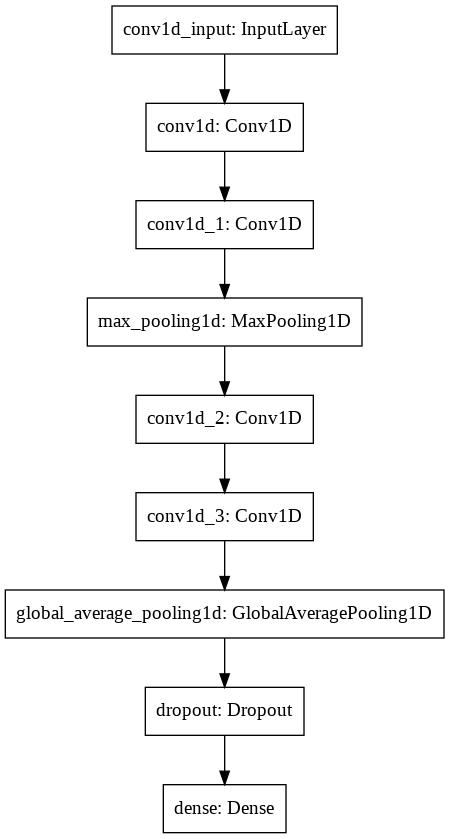

In [21]:
model_cnn1d = CNN1D()
model_cnn1d.create(dropout=True)
print("Resumen de hiperparametros de las CNN1D")
print(model_cnn1d.model.summary())
print("Arquitectura secuencial de la CNN1D")
plot_model(model_cnn1d.model, to_file='model.png')

### Entrenamiento de modelo 
Se entrenan diferentes modelos con la arquitectura propuesta para los 7 datasets obtenidos.

In [0]:
for dataset in datasets:
  model_cnn1d  = CNN1D()
  model_cnn1d.create(dropout=True)
  dataset["model"] = model_cnn1d
  #model_cnn1d_dp_es.run(x_train,y_train,early_stoping=True)

#### Entrenamiento para nivel de fuerza Tx_0x01

In [23]:
index_ds = 0
x_train = datasets[index_ds]['x_train']
y_train = datasets[index_ds]['y_train']
datasets[index_ds]['model'].run(x_train,y_train,early_stoping=True)

Train on 243 samples, validate on 61 samples
Epoch 1/200
243/243 [==============================] - 4s 16ms/sample - loss: 2.4768 - sparse_categorical_accuracy: 0.2016 - val_loss: 2.2116 - val_sparse_categorical_accuracy: 0.3607
Epoch 2/200
243/243 [==============================] - 0s 537us/sample - loss: 1.6654 - sparse_categorical_accuracy: 0.4856 - val_loss: 1.3570 - val_sparse_categorical_accuracy: 0.5246
Epoch 3/200
243/243 [==============================] - 0s 535us/sample - loss: 1.0685 - sparse_categorical_accuracy: 0.6296 - val_loss: 0.8589 - val_sparse_categorical_accuracy: 0.7377
Epoch 4/200
243/243 [==============================] - 0s 590us/sample - loss: 0.7149 - sparse_categorical_accuracy: 0.7407 - val_loss: 0.6670 - val_sparse_categorical_accuracy: 0.7705
Epoch 5/200
243/243 [==============================] - 0s 518us/sample - loss: 0.5914 - sparse_categorical_accuracy: 0.8066 - val_loss: 0.6536 - val_sparse_categorical_accuracy: 0.7213
Epoch 6/200
243/243 [==========

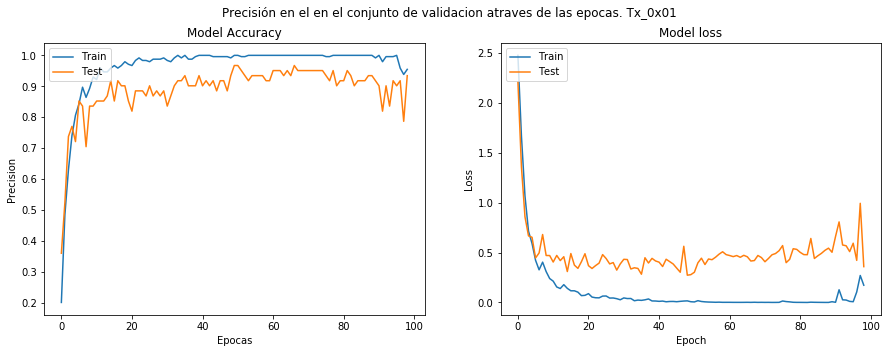

In [24]:
datasets[index_ds]['model'].vizualizate_train(visualzation_accuracy_loss_values_epochs=visualzation_accuracy_loss_values_epochs, title = "Precisión en el en el conjunto de validacion atraves de las epocas. " + datasets[index_ds]['name'] )

In [25]:
  x_test = datasets[0]["x_test"]
  y_test = datasets[0]["y_test"]
  datasets[0]['model'].evaluate(x_test=x_test,y_test=y_test)

34/34 [==============================] - 0s 1ms/sample - loss: 0.3075 - sparse_categorical_accuracy: 0.9118
Precisión en el conjunto de prueba: 0.9117646813392639
Valor de la perdidad en el conjunto de prueba: 0.30748940916622053


#### Entrenamiento para nivel de fuerza Tx_0x02

In [26]:
index_ds = 1
x_train = datasets[index_ds]['x_train']
y_train = datasets[index_ds]['y_train']
datasets[index_ds]['model'].run(x_train,y_train,early_stoping=True)

Train on 197 samples, validate on 50 samples
Epoch 1/200
197/197 [==============================] - 1s 3ms/sample - loss: 2.4077 - sparse_categorical_accuracy: 0.2132 - val_loss: 2.0294 - val_sparse_categorical_accuracy: 0.3200
Epoch 2/200
197/197 [==============================] - 0s 581us/sample - loss: 1.6012 - sparse_categorical_accuracy: 0.4721 - val_loss: 1.2104 - val_sparse_categorical_accuracy: 0.7200
Epoch 3/200
197/197 [==============================] - 0s 549us/sample - loss: 0.8958 - sparse_categorical_accuracy: 0.7157 - val_loss: 0.6676 - val_sparse_categorical_accuracy: 0.8200
Epoch 4/200
197/197 [==============================] - 0s 661us/sample - loss: 0.5625 - sparse_categorical_accuracy: 0.8274 - val_loss: 0.5929 - val_sparse_categorical_accuracy: 0.8000
Epoch 5/200
197/197 [==============================] - 0s 570us/sample - loss: 0.4578 - sparse_categorical_accuracy: 0.8426 - val_loss: 0.3887 - val_sparse_categorical_accuracy: 0.9200
Epoch 6/200
197/197 [===========

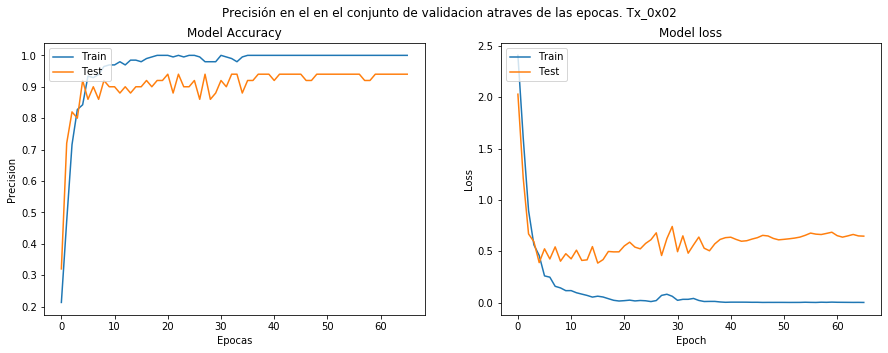

In [27]:
datasets[index_ds]['model'].vizualizate_train(visualzation_accuracy_loss_values_epochs=visualzation_accuracy_loss_values_epochs, title = "Precisión en el en el conjunto de validacion atraves de las epocas. " + datasets[index_ds]['name'] )

In [28]:
  x_test = datasets[1]["x_test"]
  y_test = datasets[1]["y_test"]
  datasets[1]['model'].evaluate(x_test=x_test,y_test=y_test)

28/28 [==============================] - 0s 471us/sample - loss: 0.2032 - sparse_categorical_accuracy: 0.9286
Precisión en el conjunto de prueba: 0.9285714030265808
Valor de la perdidad en el conjunto de prueba: 0.20318087935447693


#### Entrenamiento para nivel de fuerza Tx_0x03

In [29]:
index_ds = 2
x_train = datasets[index_ds]['x_train']
y_train = datasets[index_ds]['y_train']
datasets[index_ds]['model'].run(x_train,y_train,early_stoping=True)

Train on 217 samples, validate on 55 samples
Epoch 1/200
217/217 [==============================] - 0s 2ms/sample - loss: 2.5007 - sparse_categorical_accuracy: 0.2212 - val_loss: 2.1586 - val_sparse_categorical_accuracy: 0.3273
Epoch 2/200
217/217 [==============================] - 0s 549us/sample - loss: 1.5807 - sparse_categorical_accuracy: 0.5576 - val_loss: 1.1399 - val_sparse_categorical_accuracy: 0.6182
Epoch 3/200
217/217 [==============================] - 0s 514us/sample - loss: 0.8740 - sparse_categorical_accuracy: 0.7281 - val_loss: 0.5300 - val_sparse_categorical_accuracy: 0.9273
Epoch 4/200
217/217 [==============================] - 0s 563us/sample - loss: 0.6700 - sparse_categorical_accuracy: 0.7788 - val_loss: 0.4454 - val_sparse_categorical_accuracy: 0.8545
Epoch 5/200
217/217 [==============================] - 0s 503us/sample - loss: 0.4079 - sparse_categorical_accuracy: 0.8571 - val_loss: 0.3268 - val_sparse_categorical_accuracy: 0.8727
Epoch 6/200
217/217 [===========

In [30]:
  x_test = datasets[2]["x_test"]
  y_test = datasets[2]["y_test"]
  datasets[2]['model'].evaluate(x_test=x_test,y_test=y_test)

31/31 [==============================] - 0s 375us/sample - loss: 0.2138 - sparse_categorical_accuracy: 0.9355
Precisión en el conjunto de prueba: 0.9354838728904724
Valor de la perdidad en el conjunto de prueba: 0.21379238367080688


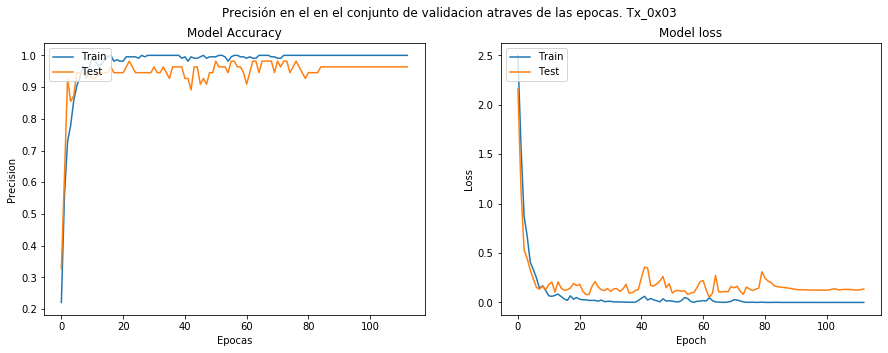

In [31]:
datasets[index_ds]['model'].vizualizate_train(visualzation_accuracy_loss_values_epochs=visualzation_accuracy_loss_values_epochs, title = "Precisión en el en el conjunto de validacion atraves de las epocas. " + datasets[index_ds]['name'] )

#### Entrenamiento para nivel de fuerza Tx_0x04

In [36]:
index_ds = 3
x_train = datasets[index_ds]['x_train']
y_train = datasets[index_ds]['y_train']
datasets[index_ds]['model'].run(x_train,y_train,early_stoping=True)

Train on 234 samples, validate on 59 samples
Epoch 1/200
234/234 [==============================] - 0s 555us/sample - loss: 0.0056 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0236 - val_sparse_categorical_accuracy: 1.0000
Epoch 2/200
234/234 [==============================] - 0s 522us/sample - loss: 0.0045 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0383 - val_sparse_categorical_accuracy: 0.9831
Epoch 3/200
234/234 [==============================] - 0s 540us/sample - loss: 0.0041 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0487 - val_sparse_categorical_accuracy: 0.9661
Epoch 4/200
234/234 [==============================] - 0s 539us/sample - loss: 0.0046 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0297 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/200
234/234 [==============================] - 0s 534us/sample - loss: 0.0125 - sparse_categorical_accuracy: 0.9957 - val_loss: 0.0708 - val_sparse_categorical_accuracy: 0.9831
Epoch 6/200
234/234 [=========

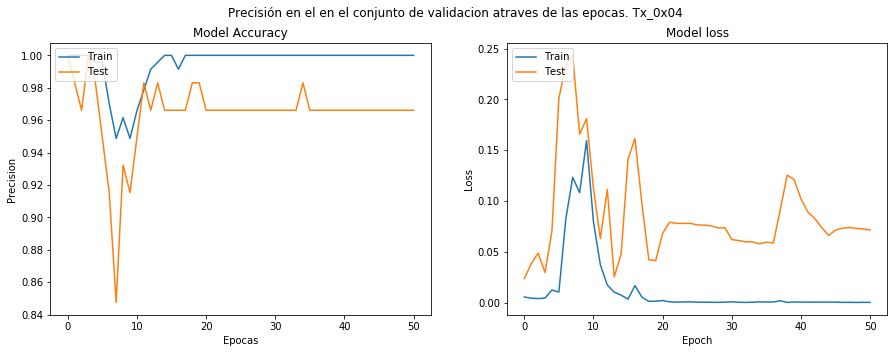

In [37]:
datasets[index_ds]['model'].vizualizate_train(visualzation_accuracy_loss_values_epochs=visualzation_accuracy_loss_values_epochs, title = "Precisión en el en el conjunto de validacion atraves de las epocas. " + datasets[index_ds]['name'] )

In [38]:
  x_test = datasets[index_ds]["x_test"]
  y_test = datasets[index_ds]["y_test"]
  datasets[index_ds]['model'].evaluate(x_test=x_test,y_test=y_test)

33/33 [==============================] - 0s 502us/sample - loss: 0.0041 - sparse_categorical_accuracy: 1.0000
Precisión en el conjunto de prueba: 1.0
Valor de la perdidad en el conjunto de prueba: 0.004082565506299121


#### Entrenamiento para nivel de fuerza Tx_0x05

In [39]:
index_ds = 4
x_train = datasets[index_ds]['x_train']
y_train = datasets[index_ds]['y_train']
datasets[index_ds]['model'].run(x_train,y_train,early_stoping=True)

Train on 222 samples, validate on 56 samples
Epoch 1/200
222/222 [==============================] - 0s 2ms/sample - loss: 2.5647 - sparse_categorical_accuracy: 0.2297 - val_loss: 2.2290 - val_sparse_categorical_accuracy: 0.3929
Epoch 2/200
222/222 [==============================] - 0s 481us/sample - loss: 1.8035 - sparse_categorical_accuracy: 0.4279 - val_loss: 1.2813 - val_sparse_categorical_accuracy: 0.6786
Epoch 3/200
222/222 [==============================] - 0s 494us/sample - loss: 1.0998 - sparse_categorical_accuracy: 0.5991 - val_loss: 0.8423 - val_sparse_categorical_accuracy: 0.6964
Epoch 4/200
222/222 [==============================] - 0s 514us/sample - loss: 0.8804 - sparse_categorical_accuracy: 0.6712 - val_loss: 0.8036 - val_sparse_categorical_accuracy: 0.6786
Epoch 5/200
222/222 [==============================] - 0s 497us/sample - loss: 0.6406 - sparse_categorical_accuracy: 0.7613 - val_loss: 0.6824 - val_sparse_categorical_accuracy: 0.7321
Epoch 6/200
222/222 [===========

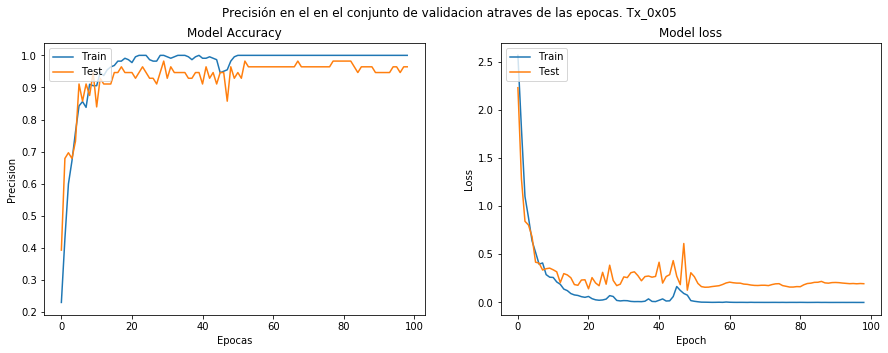

In [40]:
datasets[index_ds]['model'].vizualizate_train(visualzation_accuracy_loss_values_epochs=visualzation_accuracy_loss_values_epochs, title = "Precisión en el en el conjunto de validacion atraves de las epocas. " + datasets[index_ds]['name'] )

In [41]:
  x_test = datasets[index_ds]["x_test"]
  y_test = datasets[index_ds]["y_test"]
  datasets[index_ds]['model'].evaluate(x_test=x_test,y_test=y_test)

31/31 [==============================] - 0s 366us/sample - loss: 0.9310 - sparse_categorical_accuracy: 0.8387
Precisión en el conjunto de prueba: 0.8387096524238586
Valor de la perdidad en el conjunto de prueba: 0.9309886693954468


#### Entrenamiento para nivel de fuerza Tx_0x06

In [42]:
index_ds = 5
x_train = datasets[index_ds]['x_train']
y_train = datasets[index_ds]['y_train']
datasets[index_ds]['model'].run(x_train,y_train,early_stoping=True)

Train on 219 samples, validate on 55 samples
Epoch 1/200
219/219 [==============================] - 0s 2ms/sample - loss: 2.4429 - sparse_categorical_accuracy: 0.2877 - val_loss: 1.9831 - val_sparse_categorical_accuracy: 0.3636
Epoch 2/200
219/219 [==============================] - 0s 523us/sample - loss: 1.5022 - sparse_categorical_accuracy: 0.4840 - val_loss: 1.0753 - val_sparse_categorical_accuracy: 0.5818
Epoch 3/200
219/219 [==============================] - 0s 524us/sample - loss: 0.8505 - sparse_categorical_accuracy: 0.6941 - val_loss: 0.4742 - val_sparse_categorical_accuracy: 0.8909
Epoch 4/200
219/219 [==============================] - 0s 513us/sample - loss: 0.5253 - sparse_categorical_accuracy: 0.8356 - val_loss: 0.3263 - val_sparse_categorical_accuracy: 0.8909
Epoch 5/200
219/219 [==============================] - 0s 578us/sample - loss: 0.4303 - sparse_categorical_accuracy: 0.8630 - val_loss: 0.2721 - val_sparse_categorical_accuracy: 0.9091
Epoch 6/200
219/219 [===========

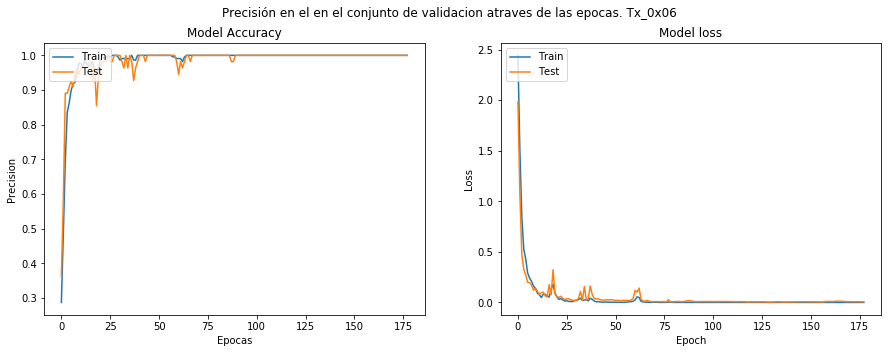

In [43]:
datasets[index_ds]['model'].vizualizate_train(visualzation_accuracy_loss_values_epochs=visualzation_accuracy_loss_values_epochs, title = "Precisión en el en el conjunto de validacion atraves de las epocas. " + datasets[index_ds]['name'] )

In [44]:
  x_test = datasets[index_ds]["x_test"]
  y_test = datasets[index_ds]["y_test"]
  datasets[index_ds]['model'].evaluate(x_test=x_test,y_test=y_test)

31/31 [==============================] - 0s 220us/sample - loss: 0.0812 - sparse_categorical_accuracy: 0.9355
Precisión en el conjunto de prueba: 0.9354838728904724
Valor de la perdidad en el conjunto de prueba: 0.0811879113316536


## Criterio de aumento de datos

In [0]:
path_data = 'https://raw.githubusercontent.com/anthonymirandag/IndoorLocalization/master/data/Tx_0x01.csv'
df = pd.read_csv(path_data)